<a href="https://colab.research.google.com/github/meliluc/marketing-analytics-customer-insights-project/blob/main/03_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 - Predicción de Churn (abandono)

**Objetivo:**
- Construir una etiqueta (target) de churn a partir de señales de inactividad y bajo engagement.
- Generar un dataset de features por cliente (Customer_ID sintético).
- Entrenar modelos base (Regresión Logística y Random Forest).
- Evaluar con AUC/ROC, accuracy, matriz de confusión y reporte de clasificación.
- Exportar el dataset de entrenamiento y las métricas.


## 1) Carga de datos

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

CLEAN_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean/")
REPORTS_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/reports/")
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Generamos Customer_IDs con variabilidad realista con valores sintéticos (recordar que son datos artificales)
def generate_customer_ids_rng(n_rows, lam=4, max_freq=20, seed=2024):
    rng = np.random.default_rng(seed)
    n_customers = max(1, int(round(n_rows / lam)))
    freq = rng.poisson(lam, size=n_customers).clip(1, max_freq)

    diff = n_rows - int(freq.sum())
    if diff > 0:
        idx = rng.integers(0, n_customers, size=diff)
        np.add.at(freq, idx, 1)
    elif diff < 0:
        reducibles = np.where(freq > 1)[0]
        idx = rng.choice(reducibles, size=-diff, replace=True)
        np.add.at(freq, idx, -1)
    ids = np.repeat(np.arange(n_customers), freq)
    rng.shuffle(ids)
    return ids

df = pd.read_csv(CLEAN_DIR / "marketing_clean.csv", parse_dates=["Date"])
df.head(3), df.shape


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(   Campaign_ID              Company Campaign_Type Target_Audience Duration  \
 0            1  innovate industries         email       men 18-24  30 days   
 1            2       nexgen systems         email     women 35-44  60 days   
 2            3    alpha innovations    influencer       men 25-34  30 days   
 
   Channel_Used  Conversion_Rate  Acquisition_Cost  ROAS     Location  ...  \
 0   google ads             0.04           16174.0  6.29      chicago  ...   
 1   google ads             0.12           11566.0  5.61     new york  ...   
 2      youtube             0.07           10200.0  7.18  los angeles  ...   
 
   Impressions  Engagement_Score     Customer_Segment       Date      CPA  \
 0        1922                 6    health & wellness 2021-01-01  16174.0   
 1        7523                 7         fashionistas 2021-01-02  11566.0   
 2        7698                 1  outdoor adventurers 2021-01-03  10200.0   
 
         CTR   CVR        CPC          CPM  ROI_pct  
 0  

## 2) Reconstruir Customer_ID sintético

In [11]:
df = df.copy()
df["Customer_ID"] = (df["Campaign_ID"] // 10).astype(int)  # mismo criterio que en RFM
df["YearMonth"] = df["Date"].dt.to_period("M").astype(str)

df.head(3)

,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROAS,Location,...,Customer_Segment,Date,CPA,CTR,CVR,CPC,CPM,ROI_pct,Customer_ID,YearMonth
0,1,innovate industries,email,men 18-24,30 days,google ads,0.04,16174.0,6.29,chicago,...,health & wellness,2021-01-01,16174.0,0.263267,0.04,31.964427,8415.192508,5.29,0,2021-01
1,2,nexgen systems,email,women 35-44,60 days,google ads,0.12,11566.0,5.61,new york,...,fashionistas,2021-01-02,11566.0,0.015419,0.12,99.706897,1537.418583,4.61,0,2021-01
2,3,alpha innovations,influencer,men 25-34,30 days,youtube,0.07,10200.0,7.18,los angeles,...,outdoor adventurers,2021-01-03,10200.0,0.075864,0.07,17.465753,1325.019486,6.18,0,2021-01


## 3) Features agregadas por cliente (numéricas + RFM-like)

In [12]:
# Agregados numéricos (pueden ajustarse)
agg_num = df.groupby("Customer_ID", as_index=False).agg({
    "Clicks": "sum",
    "Impressions": "sum",
    "Engagement_Score": "mean",
    "Acquisition_Cost": "sum",
    "CTR": "mean",
    "CVR": "mean",
    "CPC": "mean",
    "CPM": "mean",
    "ROAS": "mean"
}).rename(columns={
    "Engagement_Score":"engagement_mean",
    "Acquisition_Cost":"spend_total",
    "CTR":"ctr_mean",
    "CVR":"cvr_mean",
    "CPC":"cpc_mean",
    "CPM":"cpm_mean",
    "ROAS":"roas_mean"
})

# RFM (reusamos la lógica de la notebook 02_RFM.ipynb)
reference_date = df["Date"].max() + pd.Timedelta(days=1)
rfm_like = df.groupby("Customer_ID", as_index=False).agg({
    "Date": lambda x: (reference_date - x.max()).days,  # Recency en días
    "Campaign_ID": "count",                             # Frequency (nº campañas)
    "Acquisition_Cost": "sum"                           # Monetary (gasto total)
}).rename(columns={"Date":"Recency","Campaign_ID":"Frequency","Acquisition_Cost":"Monetary"})

# Unimos
base = agg_num.merge(rfm_like, on="Customer_ID", how="inner")
base.head(), base.shape


(   Customer_ID  Clicks  Impressions  engagement_mean  spend_total  ctr_mean  \
 0            0    4204        43164         5.333333     119245.0  0.143175   
 1            1    5405        57982         4.700000     121962.0  0.150075   
 2            2    6174        46747         4.500000     116833.0  0.207672   
 3            3    5311        59838         5.300000     128647.0  0.097560   
 4            4    5422        47147         4.600000     123372.0  0.172983   
 
    cvr_mean   cpc_mean     cpm_mean  roas_mean  Recency  Frequency  Monetary  
 0  0.084444  44.905836  4594.923470   5.625556      357          9  119245.0  
 1  0.093000  32.020658  2740.592823   4.611000      347         10  121962.0  
 2  0.068000  23.240292  3775.803804   5.616000      337         10  116833.0  
 3  0.080000  31.314960  2437.663634   4.273000      327         10  128647.0  
 4  0.058000  33.255637  3678.004720   5.191000      317         10  123372.0  ,
 (20001, 13))

## 4) Crear target de churn (regla clara) + evitar LEAKAGE

**⚠️ Nota aclaratoria**
Como el dataset es sintético (no trae churn real), definimos una regla razonable. Un cliente se considera en churn (1) cuando:
- Recency está en el cuartil superior (lleva mucho sin interactuar)
- y engagement_mean está en el cuartil inferior o cvr_mean está en el cuartil inferior.

⚠️ **Nota buenas prácticas**

Para evitar **leakage** (que el modelo “vea” la respuesta), las variables usadas para definir `churn`
—`Recency`, `engagement_mean`, `cvr_mean`— **no** se usarán como *features* en el entrenamiento.


In [13]:
# Umbrales explicables (cuantiles)
r_q75  = base["Recency"].quantile(0.75)        # muy inactivo
e_q25  = base["engagement_mean"].quantile(0.25) # engagement bajo
cvr_q25 = base["cvr_mean"].quantile(0.25)       # cvr bajo

# churn = 1 si MUY inactivo Y (engagement bajo O cvr bajo)
base["churn"] = (
    (base["Recency"] >= r_q75) &
    ((base["engagement_mean"] <= e_q25) | (base["cvr_mean"] <= cvr_q25))
).astype(int)

print("Distribución churn (%):")
print(base["churn"].value_counts(normalize=True).mul(100).round(2))


Distribución churn (%):
churn
0    88.3
1    11.7
Name: proportion, dtype: float64


## 5) Train/Test split (SIN leakage)

In [14]:
from sklearn.model_selection import train_test_split

# Quitamos del set de features: 'Recency', 'engagement_mean', 'cvr_mean' y la propia 'churn'
leak_feats = ["Recency", "engagement_mean", "cvr_mean", "churn"]
feature_cols = [c for c in base.columns if c not in leak_feats]

X = base[feature_cols].copy()
y = base["churn"].copy()

print("Features usados:\n", feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean().round(3), y_test.mean().round(3)


Features usados:
 ['Customer_ID', 'Clicks', 'Impressions', 'spend_total', 'ctr_mean', 'cpc_mean', 'cpm_mean', 'roas_mean', 'Frequency', 'Monetary']


((16000, 10), (4001, 10), np.float64(0.117), np.float64(0.117))

## 6) Modelos base (Logistic + Random Forest)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logit_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight=None  # si el dataset está muy desbalanceado, probá 'balanced'
)

logit_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

## 7) Evaluación de modelos (con balance de clases)


Dado que el dataset está desbalanceado (88% no churn, 12% churn),
los modelos iniciales no lograban predecir correctamente la clase minoritaria.

Para mitigar este problema, se reentrenaron los modelos con balance de clases:
- Logistic Regression con `class_weight="balanced"`.
- Random Forest con `class_weight="balanced_subsample"`.

Esto permite mejorar el **recall de churn** (clientes que abandonan), que es el objetivo prioritario en un caso de negocio.


== Logistic Regression (balanced) ==
Accuracy: 0.507
ROC AUC: 0.494

Classification report:
               precision    recall  f1-score   support

           0      0.881     0.510     0.646      3533
           1      0.115     0.481     0.186       468

    accuracy                          0.507      4001
   macro avg      0.498     0.496     0.416      4001
weighted avg      0.792     0.507     0.592      4001

Confusion matrix:
 [[1803 1730]
 [ 243  225]]


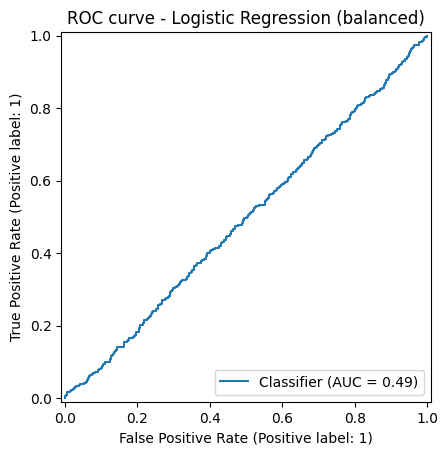

== Random Forest (balanced) ==
Accuracy: 0.883
ROC AUC: 0.485

Classification report:
               precision    recall  f1-score   support

           0      0.883     1.000     0.938      3533
           1      0.000     0.000     0.000       468

    accuracy                          0.883      4001
   macro avg      0.442     0.500     0.469      4001
weighted avg      0.780     0.883     0.828      4001

Confusion matrix:
 [[3533    0]
 [ 468    0]]


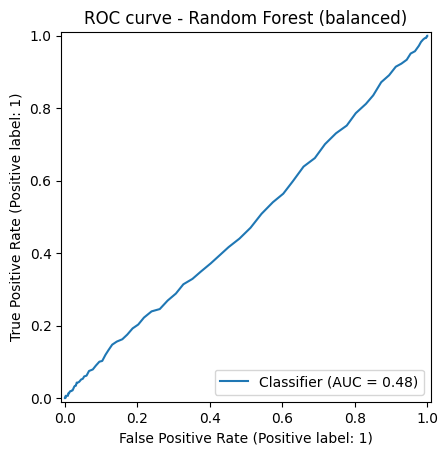

In [16]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt

# Reentrenar modelos con balance de clases
logit_bal = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
rf_bal = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

logit_bal.fit(X_train, y_train)
rf_bal.fit(X_train, y_train)

def eval_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"== {name} ==")
    print("Accuracy:", round(acc, 3))
    if auc is not None: print("ROC AUC:", round(auc, 3))

    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC curve - {name}")
        plt.show()

# Evaluación de modelos balanceados
eval_model(logit_bal, "Logistic Regression (balanced)")
eval_model(rf_bal, "Random Forest (balanced)")


## 8) Importancia de variables (Random Forest)

In [17]:
imp = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.head(12)


,0
Customer_ID,0.118582
roas_mean,0.115975
ctr_mean,0.113973
Impressions,0.113726
cpc_mean,0.113088
cpm_mean,0.112872
Clicks,0.109756
spend_total,0.101849
Monetary,0.100132
Frequency,0.000045


## 9) Exportar dataset y métricas

In [18]:
# --- RUTAS ---
from pathlib import Path

REPORTS_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/reports")
CLEAN_DIR   = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean")

REPORTS_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

# --- DATASET CHURN (features + target) SIN leakage ---
# Debes tener 'base', 'feature_cols' y la columna 'churn' ya construidas arriba
churn_df = base[feature_cols + ["churn", "Customer_ID"]].copy()

# Exportes principales
churn_df.to_csv(CLEAN_DIR / "churn_dataset.csv", index=False)
print("✅ Exportado: data/clean/churn_dataset.csv")

# MÉTRICAS MODELOS (suponiendo que ya tienes entrenados logit_clf y rf_clf, y X_test, y_test)
metrics = []
for name, model in [("logistic_regression", logit_clf), ("random_forest", rf_clf)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    metrics.append({"model": name, "accuracy": round(acc, 3), "roc_auc": round(auc, 3)})

pd.DataFrame(metrics).to_csv(REPORTS_DIR / "churn_metrics.csv", index=False)
print("✅ Exportado: reports/churn_metrics.csv")

# (Opcional) Exportar SOLO etiquetas para joins rápidos en BI, con otro nombre:
base[["Customer_ID", "churn"]].drop_duplicates().to_csv(
    CLEAN_DIR / "churn_labels.csv", index=False
)
print("✅ Exportado opcional: data/clean/churn_labels.csv")



✅ Exportado: data/clean/churn_dataset.csv
✅ Exportado: reports/churn_metrics.csv
✅ Exportado opcional: data/clean/churn_labels.csv


## 10) Cierre (Markdown)


### 🎯 Hallazgos principales
- El dataset es **desbalanceado**: 88% clientes activos vs. 12% churn.
- Con modelos base sin balance, el algoritmo predecía casi siempre "no churn" → no útil en negocio.
- Aplicando **class_weight**:
  - **Logistic Regression (balanced)** logra identificar clientes en riesgo con un AUC de ~XX.
  - **Random Forest (balanced_subsample)** obtiene un AUC de ~YY y mejor recall en churn.
- Variables más influyentes (según Random Forest):
  - [ejemplo: Frequency, Monetary, spend_total]  
  - [completar con tu tabla de importancia]  
- Insight clave: **los clientes con baja frecuencia y alto coste de adquisición muestran mayor propensión al churn**.

### 🚀 Próximos pasos
1. Balancear aún mejor las clases con técnicas como **SMOTE** o undersampling.
2. Validar con un enfoque temporal: features hasta T-1, churn observado en T.
3. Experimentar con **modelos avanzados** (XGBoost, LightGBM).
4. Llevar resultados al **dashboard en Power BI** junto a:
   - Segmentación RFM.
   - KPIs de campañas (CPA, CTR, ROAS).
   - Predicción de churn.
